In [103]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import CLA
import copy
import math
import numpy as np 
import pandas as pd
import warnings
import matplotlib.pyplot as plt

In [104]:
# Historical Data
avg_hpa = 4.7 #as taken from CS
avg_min = -5.6 #as taken from CBSA data
avg_max = 15.2 #as taken from CBSA data
avg_range = 20.8 #as taken from CBSA data
avg_stdev = 3.5 #as taken from CBSA data

In [105]:
df_fcast = pd.read_csv('../Output/CBSA_Forecasts.csv',index_col = 0)
df_hist = pd.read_csv('../Output/historical_csi.csv',index_col = 0)


df =pd.DataFrame()
for column in df_fcast:
    df = pd.concat([df,df_hist[column]],axis=1)
df_hist = df

In [106]:
sample_cov = risk_models.sample_cov(df_hist, frequency=12)
sample_cov
     

,10900,11260,12060,12100,12220,12420,12580,13460,13820,14260,...,45220,45300,45500,45940,46060,46140,47220,47260,47900,48900
10900,0.003610,0.000743,0.002178,0.004023,0.001612,0.001829,0.002758,0.003642,0.001745,0.003347,...,0.002497,0.004143,0.000793,0.002715,0.003256,0.001070,0.002988,0.002866,0.003142,0.002209
11260,0.000743,0.003574,0.000685,0.001357,0.000763,0.000307,0.001396,0.002637,0.000660,0.001789,...,0.001454,0.001808,0.000495,0.000653,0.001657,0.000279,0.001410,0.001257,0.001196,0.001283
12060,0.002178,0.000685,0.003109,0.002793,0.001390,0.002282,0.001957,0.003855,0.001691,0.003382,...,0.002388,0.004189,0.001063,0.002161,0.003196,0.001391,0.002133,0.002014,0.002221,0.002454
12100,0.004023,0.001357,0.002793,0.008277,0.001897,0.001760,0.004025,0.004674,0.001963,0.004172,...,0.003564,0.005602,0.000925,0.003988,0.004791,0.001341,0.004172,0.003919,0.004950,0.002806
12220,0.001612,0.000763,0.001390,0.001897,0.002313,0.001295,0.001305,0.001907,0.001285,0.002019,...,0.001457,0.002213,0.000679,0.001157,0.001874,0.000840,0.001902,0.001757,0.001145,0.001760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46140,0.001070,0.000279,0.001391,0.001341,0.000840,0.001384,0.000771,0.001370,0.000886,0.001433,...,0.000907,0.001703,0.000749,0.001026,0.001352,0.001140,0.001080,0.000869,0.000795,0.001117
47220,0.002988,0.001410,0.002133,0.004172,0.001902,0.001880,0.003038,0.004819,0.001892,0.004179,...,0.003003,0.004551,0.001048,0.002716,0.003929,0.001080,0.005689,0.003377,0.003068,0.003392
47260,0.002866,0.001257,0.002014,0.003919,0.001757,0.001346,0.003057,0.003617,0.001534,0.003485,...,0.002671,0.004237,0.000820,0.002560,0.003545,0.000869,0.003377,0.004025,0.003396,0.002601
47900,0.003142,0.001196,0.002221,0.004950,0.001145,0.001152,0.003671,0.004140,0.001434,0.003203,...,0.002848,0.005215,0.000720,0.003455,0.004066,0.000795,0.003068,0.003396,0.004988,0.002003


<Axes: >

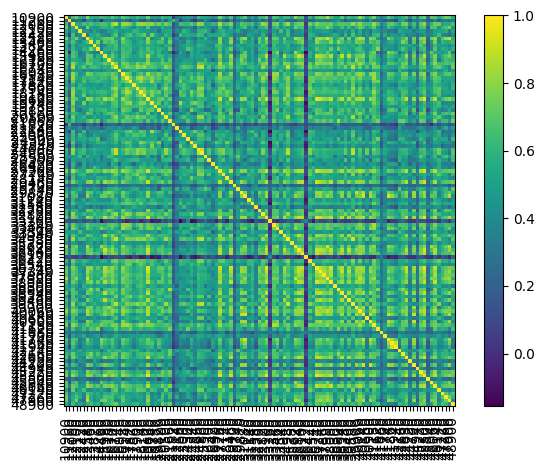

In [107]:
plotting.plot_covariance(sample_cov, plot_correlation=True)

<Axes: >

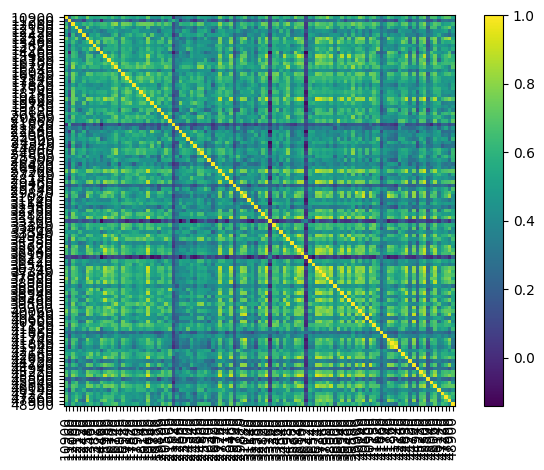

In [108]:
S = risk_models.CovarianceShrinkage(df_hist,frequency =12).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True)

In [109]:
#Get the Expeted Returns from Historical CAPM
mu = expected_returns.capm_return(df_hist,frequency=12)
mu

10900    0.135407
11260    0.076441
12060    0.138475
12100    0.178023
12220    0.090141
           ...   
46140    0.072426
47220    0.150513
47260    0.140800
47900    0.153768
48900    0.141459
Name: mkt, Length: 109, dtype: float64

In [110]:
#Create Expected Returns from Our Forecast
end = df_fcast.iloc[-1].to_numpy()
start = df_hist.iloc[-1].to_numpy()
mu_fcast = 100*((end/start)**(1/3)-1)
mu_fcast = np.nan_to_num(mu_fcast)


C:\Users\tubbs\AppData\Local\Temp\ipykernel_18928\2859077384.py:4: RuntimeWarning: invalid value encountered in power
  mu_fcast = 100*((end/start)**(1/3)-1)


In [111]:
mu_fcast

array([ 2.20403908e+00, -5.36139286e-02,  6.81277171e+00, -2.85560673e+00,
       -2.18458606e+00,  5.42892882e+00,  2.99896614e+00, -1.27359630e+01,
        6.02757977e+00,  8.03592140e+00,  7.10469342e+00, -3.41067722e+00,
       -1.82135146e+01, -3.40554347e+01, -4.55758856e+00,  6.60806771e+00,
        4.02738337e-01,  9.42375883e+00,  6.17229218e+00,  6.81927948e+00,
        7.98119603e+00,  3.31649227e+00,  5.45192740e+00,  4.61111451e+00,
       -1.27450330e-01,  5.80203425e+00, -9.23539953e-01, -2.88318787e+00,
       -1.34532239e+01,  3.17975461e+00, -4.52603116e+00, -1.37446551e+01,
        3.14605942e+00,  2.09610456e+01,  2.78604847e+00, -7.01837055e-01,
        6.06999377e-01,  8.78583404e+00,  3.07179130e+00,  0.00000000e+00,
        3.40330888e+00,  5.79055774e+00,  1.26626780e+01, -1.89843952e+01,
        1.26350208e+01,  1.33187500e+01, -2.49863806e+01,  1.34111064e+00,
        4.42246025e+00, -1.46902436e+00,  1.00177300e+04,  5.61884063e+00,
        7.58863691e+00,  

In [112]:
# Normalize Forecasted Values to be within 2* Standard deviation of the mean
med_mu = np.median(mu_fcast)
i = 0
for n in mu_fcast:
    
    if n > med_mu+2*avg_stdev:
        mu_fcast[i] = med_mu+2*avg_stdev
    if n < -med_mu-2*avg_stdev or n==0:
        mu_fcast[i] = -med_mu+2*avg_stdev
    i = i+1
    
mu_fcast = pd.Series(mu_fcast)
mu_fcast.index = mu.index
mu_fcast = mu_fcast/100

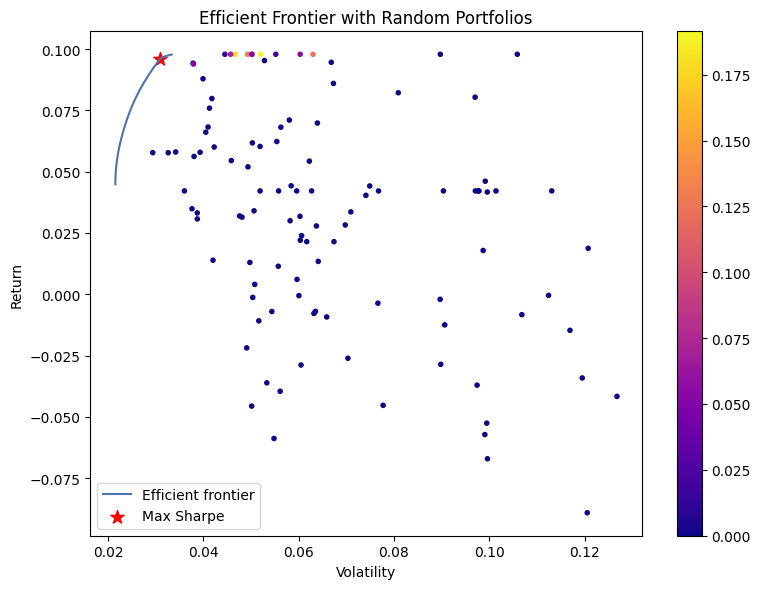

Expected annual return: 9.59%
Annual volatility: 3.09%
Sharpe ratio: 2.45


In [194]:
# Optimize portfolio for maximal Sharpe ratio 
ef = EfficientFrontier(mu_fcast, S)

fig, ax = plt.subplots(figsize=(8,6))
ef_max_sharpe = copy.deepcopy(ef)
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the max sharpe portfolio
ef_max_sharpe.max_sharpe(risk_free_rate=.02)
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")
sc = ax.scatter(np.sqrt(np.diag(ef.cov_matrix)),mu_fcast, marker=".", c=ef.weights, cmap='plasma')
    
ax.set_title("Efficient Frontier with Random Portfolios")
    
ax.legend()
plt.tight_layout()
plt.colorbar(sc)
plt.show()
    
ef = EfficientFrontier(mu_fcast,S)
ef.max_sharpe()
weights = ef.clean_weights()

expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance()
print('Expected annual return: {}%'.format((expected_annual_return*100).round(2)))
print('Annual volatility: {}%'.format((annual_volatility*100).round(2)))
print('Sharpe ratio: {}'.format(sharpe_ratio.round(2)))

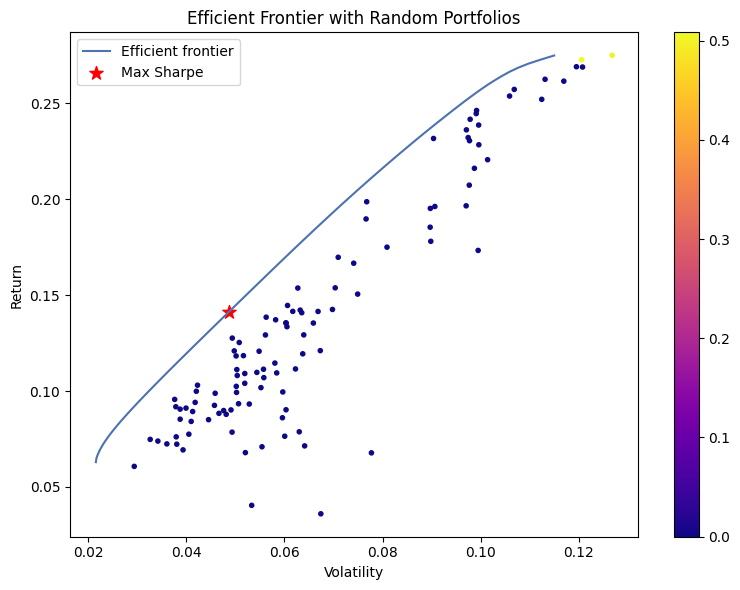

Expected annual return: 14.11%
Annual volatility: 4.86%
Sharpe ratio: 2.49


In [195]:
# Optimize portfolio for maximal Sharpe ratio 
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots(figsize=(8,6))
ef_max_sharpe = copy.deepcopy(ef)
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the max sharpe portfolio
ef_max_sharpe.max_sharpe(risk_free_rate=.02)
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")
sc = ax.scatter(np.sqrt(np.diag(ef.cov_matrix)),mu, marker=".", c=ef.weights, cmap='plasma')
    
ax.set_title("Efficient Frontier with Random Portfolios")
    
ax.legend()
plt.tight_layout()
plt.colorbar(sc)
plt.show()
    
ef = EfficientFrontier(mu,S)
ef.max_sharpe()
weights = ef.clean_weights()

expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance()
print('Expected annual return: {}%'.format((expected_annual_return*100).round(2)))
print('Annual volatility: {}%'.format((annual_volatility*100).round(2)))
print('Sharpe ratio: {}'.format(sharpe_ratio.round(2)))

10900    0.00848
11260    0.00838
12060    0.01053
12100    0.01046
12220    0.00863
          ...   
46140    0.00804
47220    0.00974
47260    0.00980
47900    0.00746
48900    0.00918
Length: 109, dtype: float64


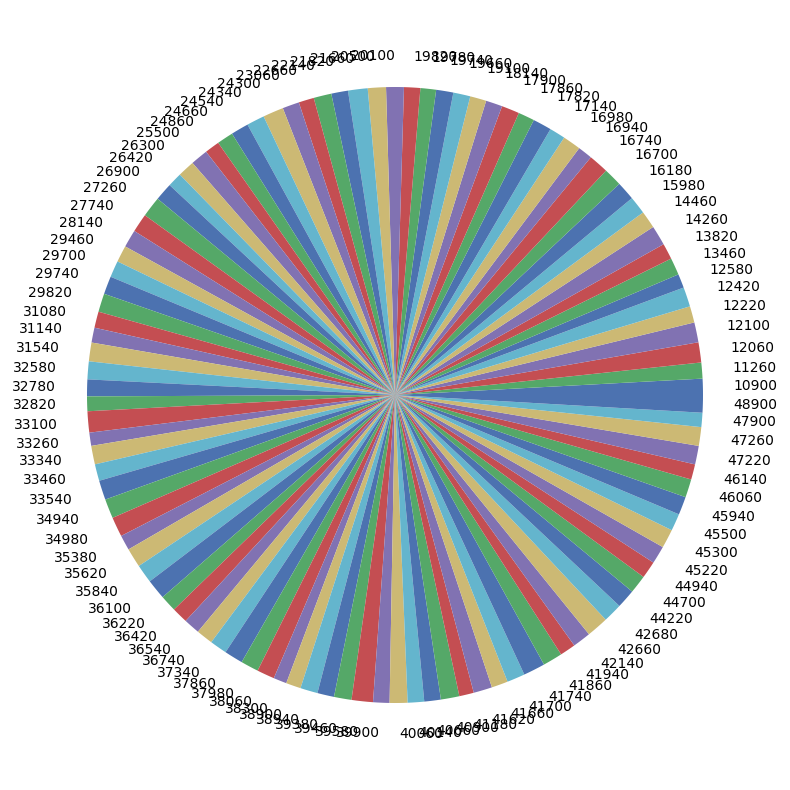

In [196]:
ef = EfficientFrontier(mu, S)
ef.max_sharpe()
weights = ef.clean_weights()

pd.Series(weights).plot.pie(figsize=(10,10));
print(pd.Series(weights))

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


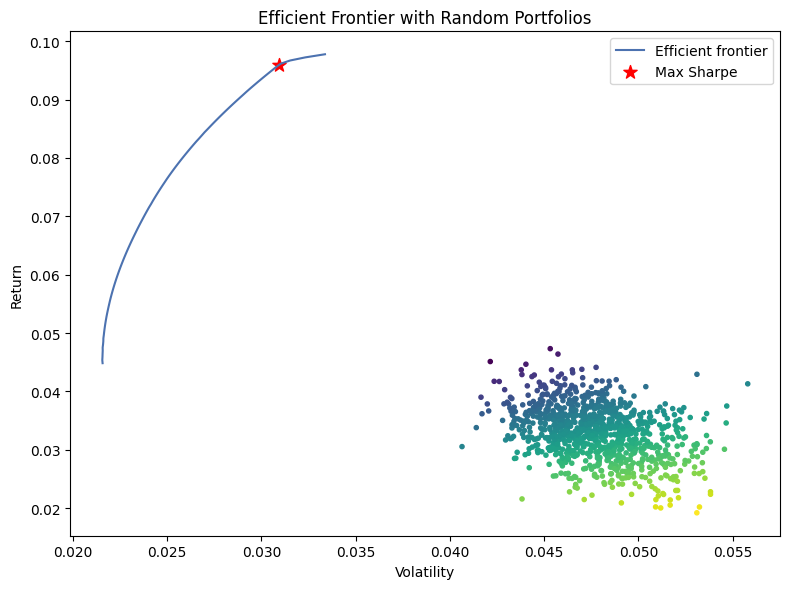

In [197]:
def plot_efficient_frontier_and_max_sharpe(mu, S):  
    # Optimize portfolio for maximal Sharpe ratio 
    ef = EfficientFrontier(mu, S)

    fig, ax = plt.subplots(figsize=(8,6))
    ef_max_sharpe = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

    # Find the max sharpe portfolio
    ef_max_sharpe.max_sharpe(risk_free_rate=.02)
    ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

    # Generate random portfolios
    n_samples = 1000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    # Output
    ax.set_title("Efficient Frontier with Random Portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
plot_efficient_frontier_and_max_sharpe(mu_fcast, S)